In [1]:
import matplotlib.pyplot as plt
%matplotlib inline 

from itertools import product

import pandas as pd
import numpy as np

from index_option_analysis import solve_marks, spot_compute_iv, spot_greeks_from

## Portfolio and Market Data

In [2]:
# Summary of market data on a recent snapshot time

#https://ycharts.com/indicators/sp_500_dividend_yield
#https://www.wsj.com/market-data/bonds
int_rate = 0.0025 #6m libor
div_yld = 0.013

spot_index = 915 # indexes have been scaled to protect the data vendors

In [3]:
# We will work with a familiar portfolio
basic_folio = pd.DataFrame.from_records(
    [(141, 'PUT', 680,  40 * 5),
     (141, 'PUT', 800, -80 * 5),
     (141, 'PUT', 855,  5 * 5),
     (141, 'PUT', 860,  35 * 5),
     (141, 'CALL', 960, -40 * 5),
     (168, 'CALL', 960,  10 * 5),
     (168, 'CALL', 965,  30 * 5),
    ],
    columns=['dte','putCall','strikePrice','quantity'],
)

basic_folio

,dte,putCall,strikePrice,quantity
0,141,PUT,680,200
1,141,PUT,800,-400
2,141,PUT,855,25
3,141,PUT,860,175
4,141,CALL,960,-200
5,168,CALL,960,50
6,168,CALL,965,150


In [4]:
# load option prices as of the snapshot time
option_data = pd.read_csv('../data/generic_at_330pm.csv')
option_data

,strikePrice,dte,putCall,bid,ask
0,40.0,22,CALL,877.80,879.24
1,80.0,22,CALL,837.82,839.24
2,120.0,22,CALL,797.82,799.24
3,160.0,22,CALL,757.84,759.26
4,200.0,22,CALL,717.86,719.26
...,...,...,...,...,...
4571,1380.0,778,PUT,457.82,462.62
4572,1400.0,778,PUT,477.06,481.86
4573,1420.0,778,PUT,496.34,501.14
4574,1440.0,778,PUT,515.66,520.46


In [5]:
dtes = sorted(option_data.dte.unique())

print('Available dtes: ')
print(dtes)

Available dtes: 
[22, 50, 85, 113, 141, 168, 204, 232, 260, 295, 323, 358, 386, 414, 449, 596, 778]


In [6]:
# add some useful fields to the option data
chains = option_data.copy()
chains['is_call'] = (chains.putCall == 'CALL')
chains['tau'] = chains['dte'] / 365.
chains['mark'] = 0.5 * (chains['bid'] + chains['ask'])
chains['spot'] = spot_index
chains['int_rate'] = int_rate
chains['div_yld'] = div_yld
chains['disc_fact'] = np.exp(-chains['tau']*chains['int_rate'])
chains['fwd'] = chains['spot'] * np.exp(chains['tau']*(chains['int_rate'] - chains['div_yld']))


## Do some portfolio analysis

In [7]:

folio_cols = ['price','delta','theta','gamma','vega','wt_vega']

folio = pd.merge(chains, basic_folio, on=['dte','putCall','strikePrice'])

# compute implied vol for each option
folio['imp_vol'] = spot_compute_iv(
    tgt=folio.mark,
    spot=folio.spot,
    strike=folio.strikePrice,
    tau=folio.tau,
    is_call=folio.is_call,
    int_rate=folio.int_rate,
    div_yld=folio.div_yld,
)

# compute greeks for each option
greeks = spot_greeks_from(
    spot=folio.spot,
    strike=folio.strikePrice,
    tau=folio.tau,
    sigma=folio.imp_vol,
    is_call=folio.is_call,
    int_rate=folio.int_rate,
    div_yld=folio.div_yld,
)

for c in folio_cols:
    folio[c] = greeks[c]

# adjust for the 100 multiplier
# note that vega needs no adjustment
folio['value'] = 100*folio['price'] # value per contract
folio['theta'] *= 100/365.          # per contract
folio['delta'] *= 100               # per contract




In [8]:
# Compute portfolio value and greeks
folio_greeks = folio[folio_cols+['value']].mul(folio.quantity, axis=0).sum()
folio_greeks

price        479.000000
delta        -21.076223
theta        776.049653
gamma         -0.087082
vega       -1406.290900
wt_vega    -2337.746264
value      47900.000000
dtype: float64

In [9]:
future_dtes = [0, 28, 56, 84, 112, 140]
spots = list(range(600,1000,5))
risk_graph = []
for fut_dte in future_dtes:
    for spot in spots:
        greeks = spot_greeks_from(
            spot=spot,
            strike=folio.strikePrice,
            tau=folio.tau - fut_dte/365.,
            is_call=folio.is_call,
            sigma=folio.imp_vol,
            int_rate=folio.int_rate,
            div_yld=folio.div_yld, 
        ) 
        risk_graph.append((fut_dte, spot, 100*(greeks['price']*folio['quantity']).sum()))

In [10]:
rg = pd.DataFrame.from_records(risk_graph, columns=['dte','spot','value'])
rg['PnL'] = rg.value - folio_greeks.value



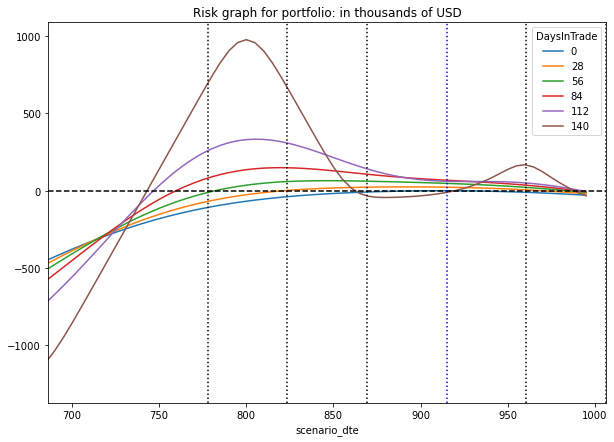

In [11]:
spot = folio.spot.iloc[0]
rgs = rg.pivot('spot','dte','PnL')
rgs.index.name = 'scenario_dte'
rgs.columns.name = 'scenario_spot'
rgs.columns.name = 'DaysInTrade'
(rgs/1000).plot(figsize=(10,7), xlim=[spot_index * 0.75, spot_index*1.1], 
         title='Risk graph for portfolio: in thousands of USD');
plt.axhline(y=0., color='k', linestyle='--')
for pct in [0.85, 0.9, 0.95, 1., 1.05, 1.1]:
    color = 'b' if pct==1 else 'k'
    plt.axvline(x=spot*pct, color=color, linestyle=':')

In [12]:
spot_15pct_down = ((spot_index * 0.85) // 5) * 5
pm_slice_15pct_down = rgs.loc[spot_15pct_down, 0]
print('Approx portfolio margin: ', np.abs(pm_slice_15pct_down).round())

Approx portfolio margin:  114290.0


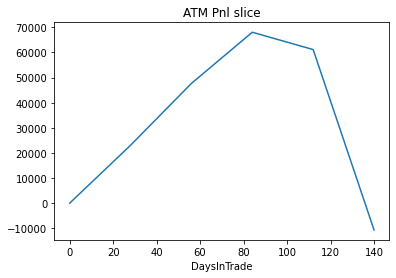

In [13]:
spot_0pct_down = ((spot_index * 1) // 5) * 5
atm_slice = rgs.loc[spot_0pct_down]
atm_slice.plot(title='ATM Pnl slice');

## Wait a minute...

Let's look at the put and call implied volatility functions.  
If they don't agree, especially near ATM strikes, we may have
an internal inconsistency.  


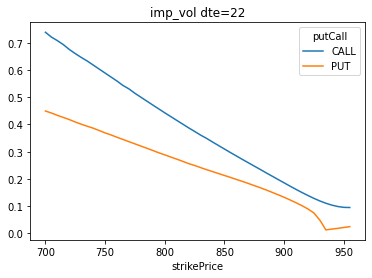

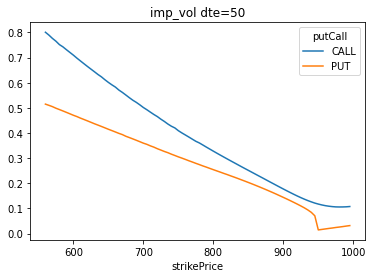

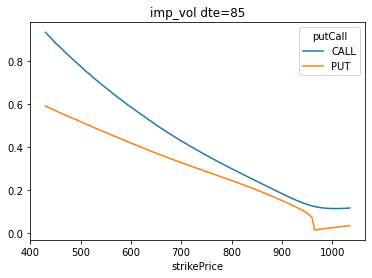

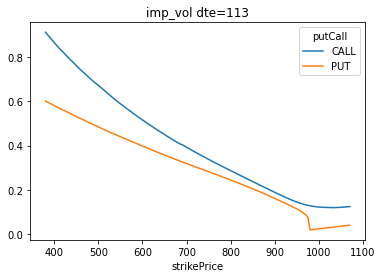

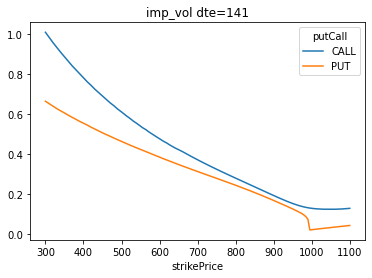

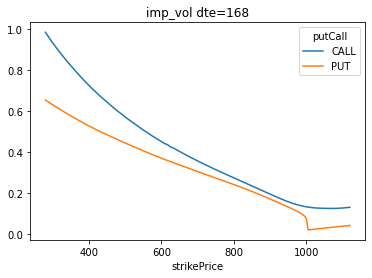

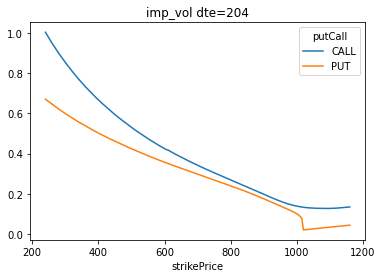

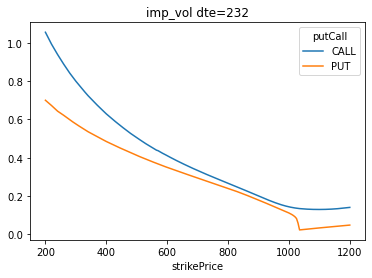

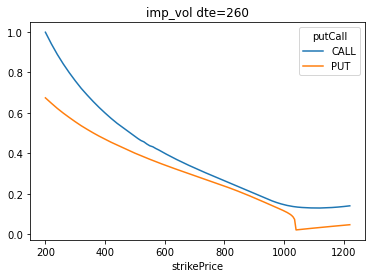

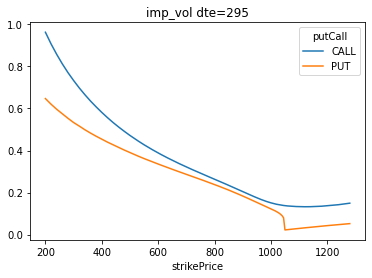

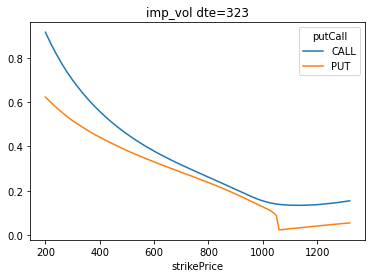

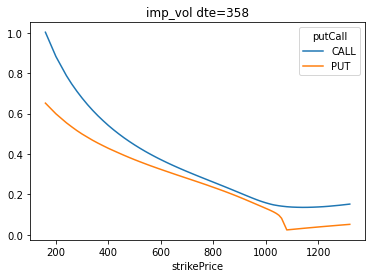

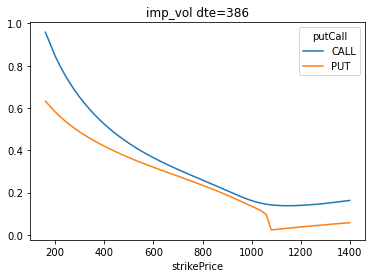

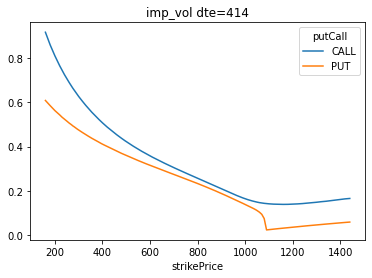

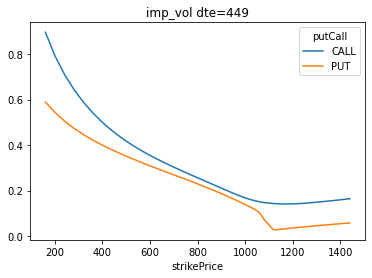

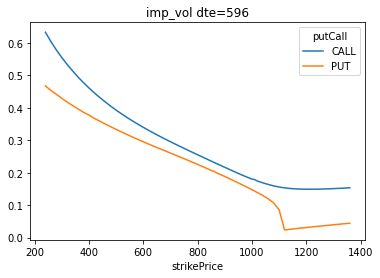

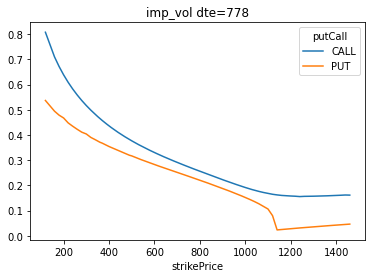

In [14]:
chains['imp_vol'] = spot_compute_iv(
    tgt=chains.mark,
    spot=chains.spot,
    strike=chains.strikePrice,
    tau=chains.tau,
    is_call=chains.is_call,
    int_rate=chains.int_rate,
    div_yld=chains.div_yld,
)

for dte,df in chains.groupby('dte'):
    df.pivot('strikePrice','putCall','imp_vol').dropna().plot(title=f'imp_vol dte={dte}');

## Oh no!  Something's wrong!

Put/call implied vol divergence indicates violation of Put-Call Parity (PCP).
- Check interest rate (should be a yield curve)
- Check dividend yield (may need to be a term-structure)
- Check spot index price (did index snapshot time agree with option snap)?

OTM implied vols look horrible.
- Bid/Ask spreads for deep OTM options are very wide. Basically delta 1 in that range.
- Using mid quotes for marks may make implied vol calculation impossible without 
adjusting the dividend yield or interest rate.